In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

import tensorflow as tf

In [ ]:
start = 0
end = 100000

range_values = np.arange(start, end)

# Create the digit representation as a 2D array
X = np.array([list(map(int, str(x).zfill(15))) for x in range_values])

# Create the labels using vectorized operations
y = np.column_stack((range_values % 2, (range_values + 1) % 2))

# Split data up into training and validation data.
split_train = StratifiedShuffleSplit(n_splits=3, test_size=0.4, train_size=0.6)
for train_index, test_index in split_train.split(X, y):
    X_val, X_train = X[test_index], X[train_index]
    y_val, y_train = y[test_index], y[train_index]

In [39]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(50, activation='sigmoid'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

In [40]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [41]:
#model.evaluate(X_train, y_train)

In [42]:
#model.evaluate(X_val, y_val)

In [43]:
model.fit(X_train, y_train, batch_size=512, epochs=1000, validation_data=(X_val, y_val))

Epoch 1/1000
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5299 - loss: 0.7008 - val_accuracy: 0.5504 - val_loss: 0.6810
Epoch 2/1000
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5476 - loss: 0.6857 - val_accuracy: 0.5667 - val_loss: 0.6739
Epoch 3/1000
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5415 - loss: 0.6739 - val_accuracy: 0.5024 - val_loss: 0.6381
Epoch 4/1000
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5598 - loss: 0.6398 - val_accuracy: 0.5994 - val_loss: 0.6211
Epoch 5/1000
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5938 - loss: 0.6244 - val_accuracy: 0.5995 - val_loss: 0.6054
Epoch 6/1000
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5985 - loss: 0.6013 - val_accuracy: 0.5963 - val_loss: 0.5695
Epoch 7/1000
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6110 - loss: 0.5720 - val_accuracy: 0.6507 - val_loss: 0.5522
Epoch 8/1000
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6386 - loss: 0.5594 

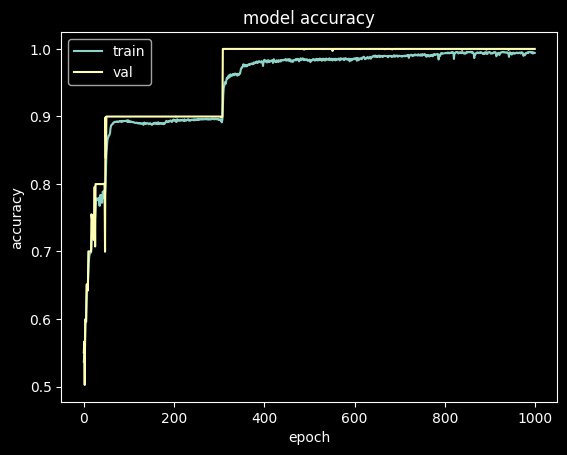

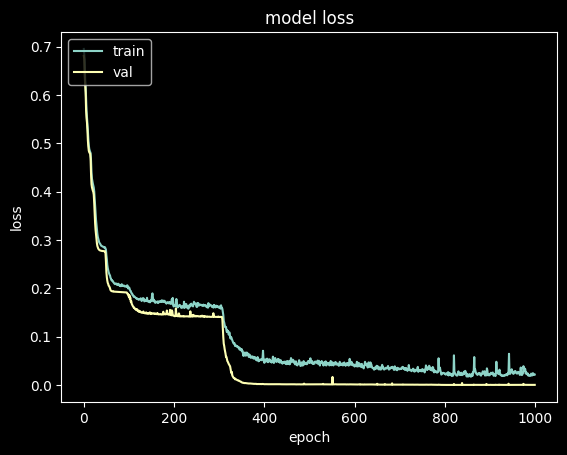

In [44]:
plt.style.use('dark_background')

plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [45]:
print(model.history.history['val_accuracy'].index(max(model.history.history['val_accuracy'])))
print(max(model.history.history['val_accuracy']))
print(model.history.history['val_loss'].index(min(model.history.history['val_loss'])))
print(min(model.history.history['val_loss']))

308
1.0
806
0.0002495298394933343


In [46]:
# adam is the goat

In [47]:
#model.save('model.keras')